## **IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para fazer a NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler

# Biblioteca para calcular a acuracia do modelo
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

from imblearn.over_sampling import ADASYN
from collections import Counter

from scipy.stats import tukey_hsd
from scipy import stats

from sklearn.svm import OneClassSVM

## **LEITURA DOS DADOS**

In [8]:
#data = pd.read_csv('../Base de Dados/Dados_49_V.csv', na_values='?')

data = pd.read_csv('../Base de Dados/Dados_10_V_FISHER.csv', na_values='?')

print(data.shape)
data.head()

(2185, 11)


,inseminacao_2cat,total_animais_prop,teste_bruc,compra_repr,venda_repr,dest_leilao,vacina_semqqidade,piquete_parto,assist_vet,tipo_assist,resul_prop
0,0,15,0,0,0,0,0,0,0,-1,0
1,0,142,0,1,1,0,1,1,0,-1,0
2,0,40,0,1,1,0,-1,1,0,-1,0
3,0,68,0,1,0,0,1,0,0,-1,0
4,0,38,0,0,0,0,0,0,0,-1,0


In [9]:
# Gerando um DataFrame das variáveis preditoras originais SEM a variável TARGET
VAR_PREDITORAS_ORIG = data.drop('resul_prop', axis = 1)

# Gerando um DataFrame somente da variavel TARGET
VAR_TARGET = data['resul_prop']

## **NORMALIZAÇÃO**

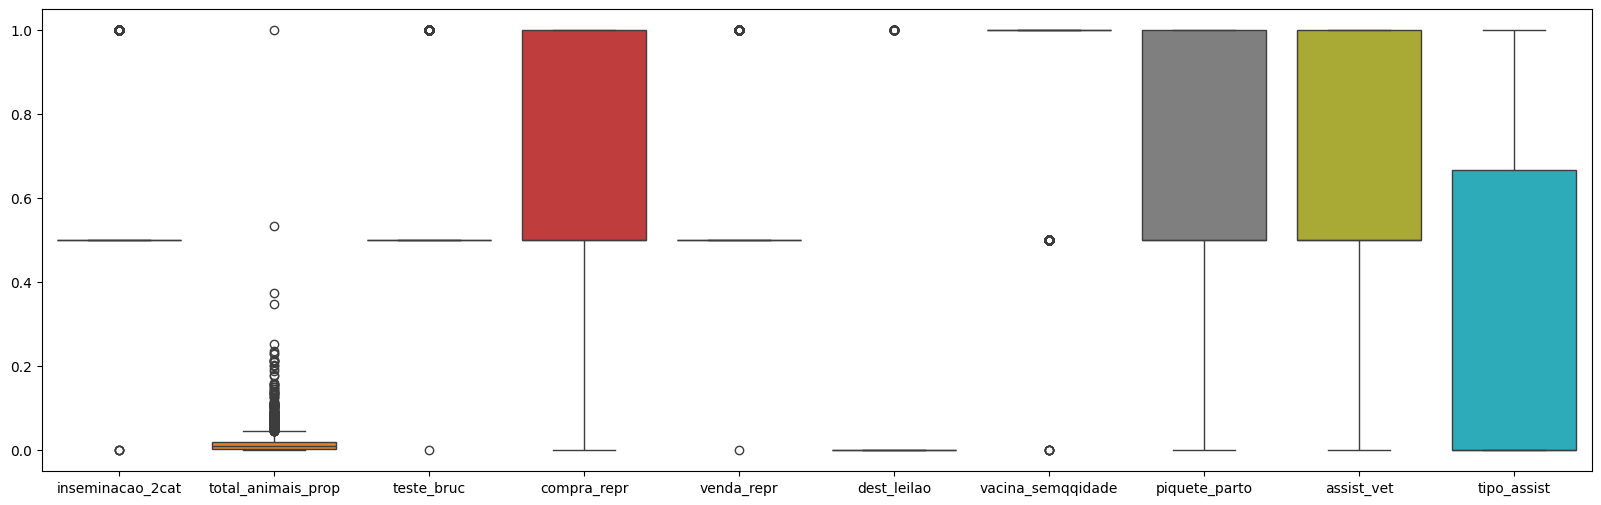

In [10]:
# Criando um objeto para NORMALIZAR os dados
obj_normalizacao = MinMaxScaler().fit(VAR_PREDITORAS_ORIG)

# Aplicando a NORMALIZAÇÃO
VAR_PREDITORAS_NORM = obj_normalizacao.transform(VAR_PREDITORAS_ORIG)

# Transformando para DataFrame e nomeando as colunas
VAR_PREDITORAS_NORM = pd.DataFrame(VAR_PREDITORAS_NORM)

VAR_PREDITORAS_NORM.columns = data.drop('resul_prop', axis = 1).columns

VAR_PREDITORAS_NORM

plt.figure(figsize=(20,6))
ax = sns.boxplot(data=VAR_PREDITORAS_NORM)

DATA_NORM = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET)
DATA_NORM_NEG = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 0').reset_index(drop=True)
DATA_NORM_POS = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 1').reset_index(drop=True)

## **SVM + Replicação**

In [11]:
accuracy_rep = []

neg_prec_rep = []
neg_recall_rep = []
neg_fscore_rep = []

pos_prec_rep = []
pos_recall_rep = []
pos_fscore_rep = []

#auc_rep = []

num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = pd.concat([DATA_NORM_POS.head(num_am_grupo_pos),DATA_NORM_POS.head(num_am_grupo_pos)], ignore_index = True)

    #-------------------------- TREINANDO SVM -------------------------------
    svm = OneClassSVM(gamma='auto', nu=0.45).fit(CLASSE_POS.drop('resul_prop', axis = 1).to_numpy())

    #-------------------------- TESTE SVM -------------------------------
    TEST_NEG = DATA_NORM_NEG

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop'].replace([0],-1)

    valores_preditos = svm.predict(X_TEST.to_numpy())

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']
   
    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    accuracy_rep.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_rep.append(report['Negativo']['precision'])
    neg_recall_rep.append(report['Negativo']['recall'])
    neg_fscore_rep.append(report['Negativo']['f1-score'])

    pos_prec_rep.append(report['Positivo']['precision'])
    pos_recall_rep.append(report['Positivo']['recall'])
    pos_fscore_rep.append(report['Positivo']['f1-score'])

    #auc_rep.append(roc_auc_score(Y_TEST, knn.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

SVM_rep = pd.DataFrame().assign(SVM_accuracy_rep=accuracy_rep,
                              SVM_neg_prec_rep=neg_prec_rep,
                              SVM_neg_recall_rep=neg_recall_rep,
                              SVM_neg_fscore_rep=neg_fscore_rep,
                              SVM_pos_prec_rep=pos_prec_rep,
                              SVM_pos_recall_rep=pos_recall_rep,
                              SVM_pos_fscore_rep = pos_fscore_rep)

SVM_rep.to_csv("../Resultados/SVM_"+str(data.shape[1]-1)+"V_rep.csv", encoding = 'utf-8', index = False)

print("FIM")


FIM


## **SVM + ADASYN**

In [12]:
accuracy_adasyn = []
neg_prec_adasyn = []
neg_recall_adasyn = []
neg_fscore_adasyn = []
pos_prec_adasyn = []
pos_recall_adasyn = []
pos_fscore_adasyn = []
#auc_adasyn = []


num_am_grupo_pos = 60

for i in range (0,100):
    #-------------------------- ADASYN -------------------------------
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS_ADASYN = DATA_NORM_POS.head(num_am_grupo_pos)

    CLASSE_NEG_ADASYN = DATA_NORM_NEG

    X_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN.drop('resul_prop', axis = 1),
        CLASSE_POS_ADASYN.drop('resul_prop', axis = 1)]).reset_index(drop=True)

    Y_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN['resul_prop'],
        CLASSE_POS_ADASYN['resul_prop']]).reset_index(drop=True)

    ada = ADASYN(sampling_strategy=0.12, n_neighbors=6)

    X_RESAMPLING, Y_RESAMPLING = ada.fit_resample(X_ADASYN_ORIGINAL, Y_ADASYN_ORIGINAL)

    #-------------------------- TREINANDO SVM -------------------------------
    CLASSE_POS = X_RESAMPLING.assign(resul_prop=Y_RESAMPLING).query('resul_prop == 1').reset_index(drop=True)
    
    svm = OneClassSVM(gamma='auto', nu=0.45).fit(CLASSE_POS.drop('resul_prop', axis = 1).to_numpy())
    
    #-------------------------- TESTE SVM -------------------------------
    TEST_NEG = DATA_NORM_NEG
    
    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop'].replace([0],-1)

    valores_preditos = svm.predict(X_TEST)

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']

    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_adasyn.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_adasyn.append(report['Negativo']['precision'])
    neg_recall_adasyn.append(report['Negativo']['recall'])
    neg_fscore_adasyn.append(report['Negativo']['f1-score'])

    pos_prec_adasyn.append(report['Positivo']['precision'])
    pos_recall_adasyn.append(report['Positivo']['recall'])
    pos_fscore_adasyn.append(report['Positivo']['f1-score'])

    #auc_adasyn.append(roc_auc_score(Y_TEST, knn.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

SVM_adasyn = pd.DataFrame().assign(SVM_accuracy_adasyn=accuracy_adasyn,
                              SVM_neg_prec_adasyn=neg_prec_adasyn,
                              SVM_neg_recall_adasyn=neg_recall_adasyn,
                              SVM_neg_fscore_adasyn=neg_fscore_adasyn,
                              SVM_pos_prec_adasyn=pos_prec_adasyn,
                              SVM_pos_recall_adasyn=pos_recall_adasyn,
                              SVM_pos_fscore_adasyn = pos_fscore_adasyn)

SVM_adasyn.to_csv("../Resultados/SVM_"+str(data.shape[1]-1)+"V_adasyn.csv", encoding = 'utf-8', index = False)

print("FIM")

c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\P

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


## **SVM CONTROLE**

In [13]:
accuracy_contr = []

neg_prec_contr = []
neg_recall_contr = []
neg_fscore_contr = []

pos_prec_contr = []
pos_recall_contr = []
pos_fscore_contr = []

#auc_contr = []

num_am_grupo_pos = 60

for i in range (0,100):
    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = DATA_NORM_POS.head(num_am_grupo_pos)

    #-------------------------- TREINANDO SVM -------------------------------
    svm = OneClassSVM(gamma='auto', nu=0.45).fit(CLASSE_POS.drop('resul_prop', axis = 1).to_numpy())

    #-------------------------- TESTE SVM -------------------------------
    TEST_NEG = DATA_NORM_NEG

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop'].replace([0],-1)

    valores_preditos = svm.predict(X_TEST)


    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']

    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_contr.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_contr.append(report['Negativo']['precision'])
    neg_recall_contr.append(report['Negativo']['recall'])
    neg_fscore_contr.append(report['Negativo']['f1-score'])

    pos_prec_contr.append(report['Positivo']['precision'])
    pos_recall_contr.append(report['Positivo']['recall'])
    pos_fscore_contr.append(report['Positivo']['f1-score'])

    #auc_contr.append(roc_auc_score(Y_TEST, knn.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

SVM_contr = pd.DataFrame().assign(SVM_accuracy_contr=accuracy_contr,
                              SVM_neg_prec_contr=neg_prec_contr,
                              SVM_neg_recall_contr=neg_recall_contr,
                              SVM_neg_fscore_contr=neg_fscore_contr,
                              SVM_pos_prec_contr=pos_prec_contr,
                              SVM_pos_recall_contr=pos_recall_contr,
                              SVM_pos_fscore_contr = pos_fscore_contr)

SVM_contr.to_csv("../Resultados/SVM_"+str(data.shape[1]-1)+"V_contr.csv", encoding = 'utf-8', index = False)

print("FIM")

c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\P

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\P

## **ESTATÍSTICA**

### **AUC**

9.510862949971779
8.178449143412719e-05


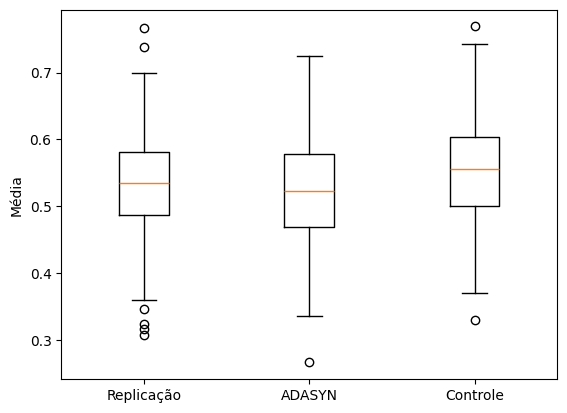

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.007     0.461    -0.007     0.022
 (0 - 2)     -0.019     0.007    -0.034    -0.004
 (1 - 0)     -0.007     0.461    -0.022     0.007
 (1 - 2)     -0.027     0.000    -0.041    -0.012
 (2 - 0)      0.019     0.007     0.004     0.034
 (2 - 1)      0.027     0.000     0.012     0.041



In [21]:
f_value, p_value = stats.f_oneway(auc_rep, auc_adasyn, auc_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([auc_rep, auc_adasyn, auc_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(auc_rep, auc_adasyn, auc_contr)
print(res)

### **ACCURACY**

9005.214140982638
0.0


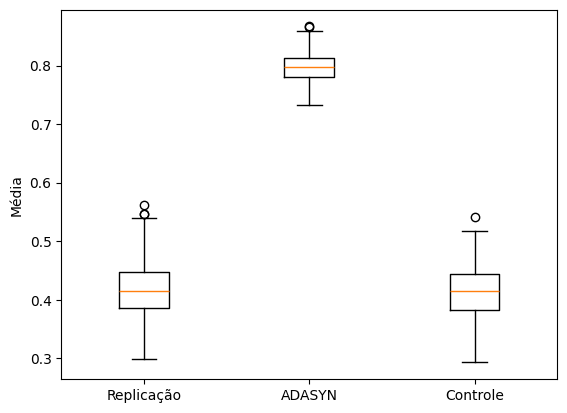

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.379     0.000    -0.387    -0.371
 (0 - 2)      0.002     0.784    -0.006     0.010
 (1 - 0)      0.379     0.000     0.371     0.387
 (1 - 2)      0.381     0.000     0.373     0.389
 (2 - 0)     -0.002     0.784    -0.010     0.006
 (2 - 1)     -0.381     0.000    -0.389    -0.373



In [24]:
f_value, p_value = stats.f_oneway(accuracy_rep, accuracy_adasyn, accuracy_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([accuracy_rep, accuracy_adasyn, accuracy_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(accuracy_rep, accuracy_adasyn, accuracy_contr)
print(res)

### **NEGATIVO PRECISION**

33.33975529866199
1.080508707874829e-14


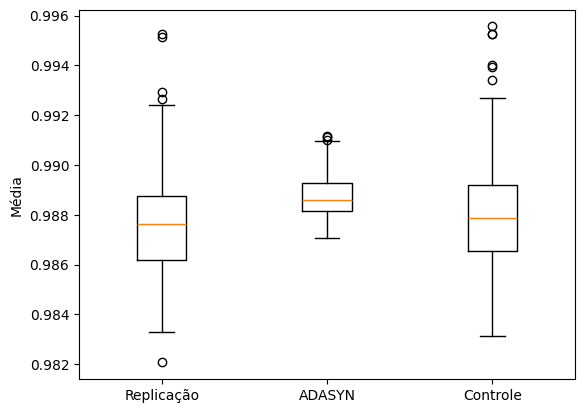

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.001     0.000    -0.001    -0.001
 (0 - 2)     -0.000     0.019    -0.001    -0.000
 (1 - 0)      0.001     0.000     0.001     0.001
 (1 - 2)      0.001     0.000     0.000     0.001
 (2 - 0)      0.000     0.019     0.000     0.001
 (2 - 1)     -0.001     0.000    -0.001    -0.000



In [25]:
f_value, p_value = stats.f_oneway(neg_prec_rep, neg_prec_adasyn, neg_prec_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_prec_rep, neg_prec_adasyn, neg_prec_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_prec_rep, neg_prec_adasyn, neg_prec_contr)
print(res)

### **POSITIVO PRECISION**

110.08554820762924
1.760877997733059e-43


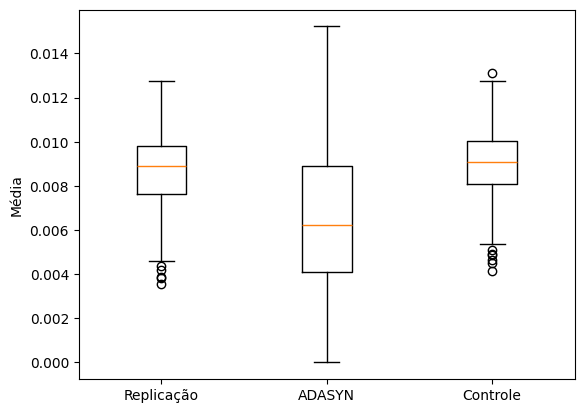

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.002     0.000     0.002     0.003
 (0 - 2)     -0.000     0.338    -0.001     0.000
 (1 - 0)     -0.002     0.000    -0.003    -0.002
 (1 - 2)     -0.003     0.000    -0.003    -0.002
 (2 - 0)      0.000     0.338    -0.000     0.001
 (2 - 1)      0.003     0.000     0.002     0.003



In [26]:
f_value, p_value = stats.f_oneway(pos_prec_rep, pos_prec_adasyn, pos_prec_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_prec_rep, pos_prec_adasyn, pos_prec_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_prec_rep, pos_prec_adasyn, pos_prec_contr)
print(res)

### **NEGATIVO RECALL**

8763.050557449247
0.0


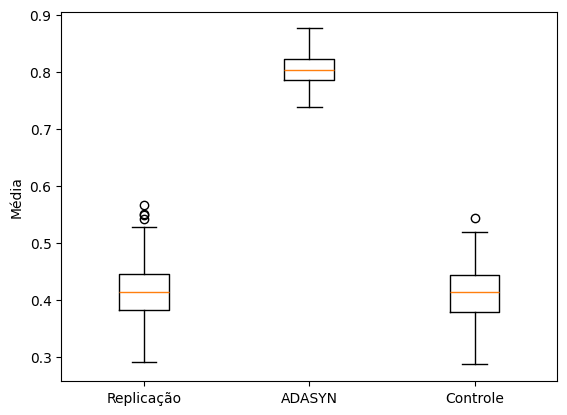

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.387     0.000    -0.395    -0.379
 (0 - 2)      0.002     0.762    -0.006     0.010
 (1 - 0)      0.387     0.000     0.379     0.395
 (1 - 2)      0.389     0.000     0.381     0.397
 (2 - 0)     -0.002     0.762    -0.010     0.006
 (2 - 1)     -0.389     0.000    -0.397    -0.381



In [27]:
f_value, p_value = stats.f_oneway(neg_recall_rep, neg_recall_adasyn, neg_recall_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_recall_rep, neg_recall_adasyn, neg_recall_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_recall_rep, neg_recall_adasyn, neg_recall_contr)
print(res)

### **POSITIVO RECALL**

1174.9789897911105
2.692309565164296e-251


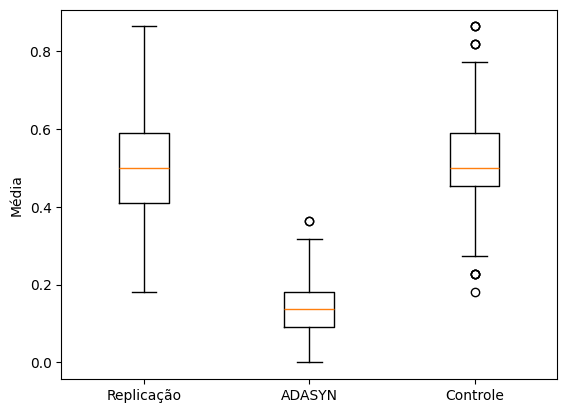

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.370     0.000     0.349     0.391
 (0 - 2)     -0.018     0.126    -0.039     0.004
 (1 - 0)     -0.370     0.000    -0.391    -0.349
 (1 - 2)     -0.387     0.000    -0.409    -0.366
 (2 - 0)      0.018     0.126    -0.004     0.039
 (2 - 1)      0.387     0.000     0.366     0.409



In [28]:
f_value, p_value = stats.f_oneway(pos_recall_rep, pos_recall_adasyn, pos_recall_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_recall_rep, pos_recall_adasyn, pos_recall_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_recall_rep, pos_recall_adasyn, pos_recall_contr)
print(res)

### **NEGATIVO F1-SCORE**

5989.686087068585
0.0


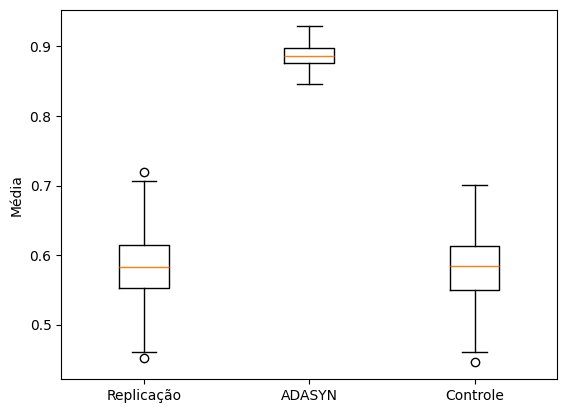

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.302     0.000    -0.309    -0.294
 (0 - 2)      0.002     0.766    -0.005     0.010
 (1 - 0)      0.302     0.000     0.294     0.309
 (1 - 2)      0.304     0.000     0.297     0.312
 (2 - 0)     -0.002     0.766    -0.010     0.005
 (2 - 1)     -0.304     0.000    -0.312    -0.297



In [29]:
f_value, p_value = stats.f_oneway(neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr)
print(res)

### **POSITIVO F1-SCORE**

133.5989053411068
1.6383272826321498e-51


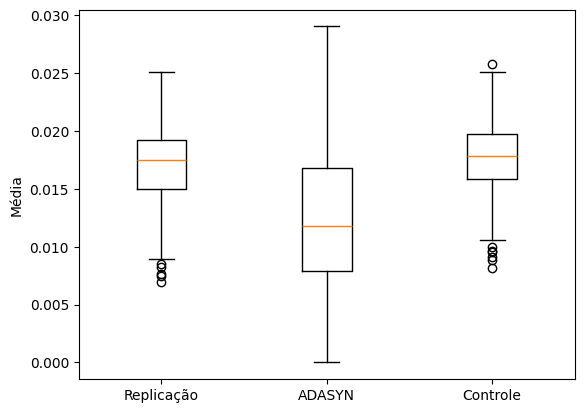

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.005     0.000     0.004     0.006
 (0 - 2)     -0.001     0.324    -0.001     0.000
 (1 - 0)     -0.005     0.000    -0.006    -0.004
 (1 - 2)     -0.006     0.000    -0.006    -0.005
 (2 - 0)      0.001     0.324    -0.000     0.001
 (2 - 1)      0.006     0.000     0.005     0.006



In [30]:
f_value, p_value = stats.f_oneway(pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr)
print(res)